# <font color='purple'>Predicting Song Genres Using Lyrical Analysis</font>

<i>Authors</i>: Zachary Zalman, Jacob Mannix

<i>Date</i>: 16 May 2020

### Load In Needed Materials and Functions

In [13]:
import pandas as pd
from datetime import datetime
from tqdm import tqdm_notebook as tqdm
import ast
import re
from statistics import mean

import numpy as np

import spacy

import gensim
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument

from sklearn.utils import resample
from sklearn import utils
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

from nltk.tokenize.treebank import TreebankWordDetokenizer

import tensorflow as tf

import keras

from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras import layers
from tensorflow.keras import initializers

import matplotlib.pyplot as plt

spacy.prefer_gpu()

False

In [14]:
# define a function to turn the string of lyric tokens into a list of lyric tokens
def format_column(text):

    lyrics_list = ast.literal_eval(text)
    
    result = []
    
    # loop through every lyric to remove the newline character
    for entry in lyrics_list:

        if entry != '\n ':
            result.append(entry)
        else:
            continue
    
    return result

### First Time Creation of Tokens

In [3]:
# load in the lyrics data set
first_df = pd.read_csv("lyrics.csv")

In [ ]:
# create a song id number by renaming the index
first_df.rename(columns={"index":"song_id"}, inplace=True)
first_df.shape

In [ ]:
first_df.dropna(subset=['lyrics'], inplace=True)
first_df.shape

In [ ]:
# split the dataframe
info = first_df[["song_id", "song", "year", "artist", "genre"]]
lyrics = first_df[["song_id", "lyrics"]]

print(info.columns)
print(lyrics.columns)

In [ ]:
# load the spaCy object with the english corpus
nlp = spacy.load("en_core_web_md")

Creating a tokenizer pipeline

In [ ]:
# define the lemmatizer function
def lemmatizer(doc):
    # remove the PRON (which are pronouns after lemming)
    doc = [token.lemma_ for token in doc if token.lemma_ != '-PRON-']
    doc = u' '.join(doc)
    return nlp.make_doc(doc)

def remove_punct(doc):
    # remove punctuation -> Use token.text to return strings, needed for Gensim.
    doc = [token.text for token in doc if token.is_punct != True]
    return doc


# add_pipe adds the function to the tokenizer
nlp.add_pipe(lemmatizer,name='lemmatizer',after='ner')
nlp.add_pipe(remove_punct, name="punct", last=True)

In [ ]:
# get the column of lyrics
doc = lyrics.lyrics
doc

In [ ]:
# check to see if any lyrics are missing
doc.isna().sum()

In [ ]:
# laptop time to run = 
# desktop time to run = 

doc_list = []

# go through each song
for doc in tqdm(doc):
    
    # tokenize the document
    pr = nlp(doc)
    
    # add it to the list
    doc_list.append(pr)

In [ ]:
# check a list of tokens
doc_list[0]

In [ ]:
# turn the list into a series, then turn it into a dataframe
temp = pd.DataFrame(pd.Series(doc_list), columns=["tokens"])

# reset the indices of the original df and the token df
temp.reset_index(drop=True, inplace=True)
first_df.reset_index(drop=True, inplace=True)

# merge the tokens df onto the original df using the indicies
df_with_tokens = pd.merge(first_df, temp, left_index=True, right_index=True)

In [ ]:
# save the df
# df_with_tokens.to_csv("lyrics_with_tokens.txt", sep="|", index=False)

## Balancing the Classes

In [19]:
# load in the dat set if it has already been created
df = pd.read_csv("lyrics_with_tokens.txt", sep="|")

# filter out the unknown genres
df = df[df.genre != "Not Available"]
df = df[df.genre != "Other"]
df.genre.value_counts()
df

,song_id,song,year,artist,genre,lyrics,tokens
0,0,ego-remix,2009,beyonce-knowles,Pop,"Oh baby, how you doing?\nYou know I'm gonna cu...","['oh', 'baby', 'how', 'do', '\n ', 'know', 'be..."
1,1,then-tell-me,2009,beyonce-knowles,Pop,"playin' everything so easy,\nit's like you see...","['playin', 'everything', 'so', 'easy', '\n ', ..."
2,2,honesty,2009,beyonce-knowles,Pop,If you search\nFor tenderness\nIt isn't hard t...,"['if', 'search', '\n ', 'for', 'tenderness', '..."
3,3,you-are-my-rock,2009,beyonce-knowles,Pop,"Oh oh oh I, oh oh oh I\n[Verse 1:]\nIf I wrote...","['oh', 'oh', 'oh', 'oh', 'oh', 'oh', '\n ', 'v..."
4,4,black-culture,2009,beyonce-knowles,Pop,"Party the people, the people the party it's po...","['party', 'the', 'people', 'the', 'people', 't..."
...,...,...,...,...,...,...,...
266552,362232,who-am-i-drinking-tonight,2012,edens-edge,Country,"I gotta say\nBoy, after only just a couple of ...","['got', 'to', 'say', '\n ', 'boy', 'after', 'o..."
266553,362233,liar,2012,edens-edge,Country,I helped you find her diamond ring\nYou made m...,"['help', 'find', 'diamond', 'ring', '\n ', 'ma..."
266554,362234,last-supper,2012,edens-edge,Country,Look at the couple in the corner booth\nLooks ...,"['look', 'at', 'the', 'couple', 'in', 'the', '..."
266555,362235,christ-alone-live-in-studio,2012,edens-edge,Country,When I fly off this mortal earth\nAnd I'm meas...,"['when', 'fly', 'off', 'this', 'mortal', 'eart..."


In [20]:
# get the breakdown of the genre counts
genre_counts = df['genre'].value_counts()
print(genre_counts)
genre_counts[7]

Rock          109235
Pop            40466
Hip-Hop        24850
Metal          23759
Country        14387
Jazz            7971
Electronic      7966
R&B             3401
Indie           3149
Folk            2243
Name: genre, dtype: int64


3401

In [21]:
# get separate dfs for all the genres
df_rock = df[df.genre == 'Rock']
df_pop = df[df.genre == 'Pop']
df_hiphop = df[df.genre == 'Hip-Hop']
df_metal = df[df.genre == 'Metal']
df_country = df[df.genre == 'Country']
df_jazz = df[df.genre == 'Jazz']
df_electronic = df[df.genre == 'Electronic']
df_rb = df[df.genre == 'R&B']
df_indie = df[df.genre == 'Indie']
df_folk = df[df.genre == 'Folk']

# Downsample all larger genres to the same as R&B (the other lower ones are close enough to R&B to keep it balanced)
df_rock = resample(df_rock, replace=False, n_samples=genre_counts[7], random_state=123)
df_pop = resample(df_pop, replace=False, n_samples=genre_counts[7], random_state=123)
df_hiphop = resample(df_hiphop, replace=False, n_samples=genre_counts[7], random_state=123)
df_metal = resample(df_metal, replace=False, n_samples=genre_counts[7], random_state=123)
df_country = resample(df_country, replace=False, n_samples=genre_counts[7], random_state=123)
df_jazz = resample(df_jazz, replace=False, n_samples=genre_counts[7], random_state=123)
df_electronic = resample(df_electronic, replace=False, n_samples=genre_counts[7], random_state=123)
 
# combine all the genres
df = pd.concat([df_rock,df_pop,df_hiphop,df_metal,df_country,df_jazz,df_electronic, df_rb, df_indie, df_folk])

# delete the uneeded variables
del df_rock
del df_pop
del df_hiphop
del df_metal
del df_country
del df_jazz
del df_electronic
del df_rb
del df_indie
del df_folk

print("Balanced Genre Breakdown:")
print(df['genre'].value_counts())
print('')
print("New Dataframe Shape:",df.shape)

Balanced Genre Breakdown:
Hip-Hop       3401
Rock          3401
Pop           3401
R&B           3401
Jazz          3401
Electronic    3401
Country       3401
Metal         3401
Indie         3149
Folk          2243
Name: genre, dtype: int64

New Dataframe Shape: (32600, 7)


## Processing the Tokens

Define the lyric list and genre list

In [22]:
# get the tokens of the lyrics, and turn it into a list
lyrics_list = df['tokens']
lyrics_list = lyrics_list.to_list()

lyr_list = []

# loop through all of the songs, and get a list of the tokens from each string
for lyr in tqdm(lyrics_list):
    temp = ast.literal_eval(lyr)
    lyr_list.append(temp)

del lyrics_list

len(lyr_list)

C:\Users\blitz\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


32600

In [23]:
# get the genres and turn it into a list
genre_list = df['genre']
gen_list = genre_list.to_list()

del genre_list

len(gen_list)

32600

Turn tokens list into a string of lyrics

In [24]:
result3 = []

# loop through all the songs in the dataset
for song in tqdm(lyr_list):
    
    result = []
    result2 = []
    tmp = []
    
    # loop through all the lines in a song
    for word in song:
    
        # if the token is a newline, replace it with a period. otherwise append the token to the list
        if word != '\n ':
            tmp.append(word)
        else:
            tmp.append('.')
            result.append(tmp)
            tmp = []
        
    # loop through all the lines again
    for index, value in enumerate(result):

        # lowercase everyhing and turn into a string
        temp_lower = [x.lower() for x in value]
        temp = " ".join(temp_lower)
        
        # skip the line if it is a verse indicator
        if re.search(r"verse [1-9]", temp):
            continue
            
        # remove any song markers from the data (these are single item lists with values that indicate song parts)
        if temp != 'chorus' and temp != 'intro' and temp != 'outro hook' and temp != 'bridge' and temp != 'pre hook' and temp != 'hook':
            result2.append(temp_lower)
    
    # append the processed song to the list
    result3.append(result2)

C:\Users\blitz\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


In [25]:
result3[0]

[['say', 'be', 'ok', '.'],
 ['that', 'have', 'to', 'sleep', 'alone', 'anyway', '.'],
 ['tell', 'why', 'do', 'pretend', '.'],
 ['the',
  'passion',
  'in',
  'eye',
  'be',
  'not',
  'appropriate',
  'for',
  'friend',
  '.'],
 ['say', 'heart', 'be', 'dead', '.'],
 ['see', 'right', 'through', '.'],
 ['heart', 'be', 'blaze', 'red', '.'],
 ['gaze', 'can', 'not', 'escape', 'sense', '.'],
 ['know', 'desire', 'hide', 'behind', 'defence', '.'],
 ['say', 'heart', 'be', 'dead', '.'],
 ['see', 'right', 'through', '.'],
 ['heart', 'be', 'blaze', 'red', '.'],
 ['tell', 'how', 'long', 'will', 'control', '.'],
 ['the', 'longing', 'for', 'deep', 'inside', 'soul', '.'],
 ['say', 'heart', 'be', 'dead', '.'],
 ['see', 'right', 'through', '.']]

In [26]:
lyr_list_final = []

# loop through all the songs
for song in tqdm(result3):
    
    lyr_list_str = []
    
    # loop through each line in the song, and merge all the tokens together
    for i in range(len(song)):
        temp = TreebankWordDetokenizer().detokenize(song[i])
        lyr_list_str.append(temp)
    
    # turn the list of strings into one string
    lyr_list_str = ", ".join(lyr_list_str)
    
    # replace the list element separator with a period to show line end
    lyr_list_str = lyr_list_str.replace('.,', '')
    
    # append the lyrics string to the list
    lyr_list_final.append(lyr_list_str)

C:\Users\blitz\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


In [27]:
lyr_list_final[7765]

"the water level's rise the water level's rise everyone alive sing who will turn the tide bring about land grab sand bag bring out be hard to yell with the atlantic in mouth there be crack in the surface crack in the surface tick tick tick tick crack in the surface crack in the surface tick tick tick tick tick tick tick tick one become two become three become four sound wave run city like parkour provokin encore know want more that be what be do this for four become three become two become one the metamorphosis cannot be undo burst forth from the land toward the sun and transform the advance have begin like mary j be o bliged to hollerate and prophesize nostradamus on the topic often drop on open mic when both side be vocalize the crowd spit the dop line effort gain significance like overdrive of dopamine these narcissist forget to do exercise confused by what success imply name drop successive try in drive thrus to get extra fry emancipating free speech when run mouth terminal cancer 

In [28]:
# create a dataframe of the lyrics and genre from the two lists
df2 = pd.DataFrame(lyr_list_final)
df2['genre'] = gen_list
df2.columns = ('lyrics', 'genre')
df2

,lyrics,genre
0,say be ok that have to sleep alone anyway tell...,Rock
1,hello again be and kinda always like use to be...,Rock
2,there s a mighty presence in the room right no...,Rock
3,be a heartbreak even situation nothing lose an...,Rock
4,whisper wind come uninvited look for somewhere...,Rock
...,...,...
32595,if be a melody be quite sure would be in a mov...,Folk
32596,wish this air could clean chest need a quiet d...,Folk
32597,where have all people go where be skin when be...,Folk
32598,do not wanna know if miss do not wanna know if...,Folk


In [ ]:
# delete unneeded variables
# del lyr_list_final
# del gen_list
# del lyr_list_str
# del result3
# del result2
# del result
# del lyr_list

## Vanilla NN With Doc2Vec

In [29]:
# shuffle the df before splitting
df = df.sample(frac=1.0, random_state=99)
df.reset_index(inplace=True, drop=True)
df

,song_id,song,year,artist,genre,lyrics,tokens
0,361917,the-law-of-confession,2009,donald-lawrence,Hip-Hop,Man can't cannot live by bread alone\nBut by e...,"['man', 'can', 'not', 'can', 'not', 'live', 'b..."
1,32198,get-down,2006,all-saints,Pop,"The way you're movin' your body,\nAin't showin...","['the', 'way', 'be', 'movin', 'body', '\n ', '..."
2,181693,the-mask,2007,danger-doom,Hip-Hop,"Head on straight, mask on crooked\nExit stage ...","['head', 'on', 'straight', 'mask', 'on', 'croo..."
3,87896,all-things-are-possible,2008,darlene-zschech,Hip-Hop,"Almighty God my Redeemer\nMy hiding place, my ...","['Almighty', 'God', 'Redeemer', '\n ', 'hiding..."
4,229161,alabao-english,2006,enrique-iglesias,Pop,When I'm with you a chain reaction\nLike a rus...,"['when', 'be', 'with', 'a', 'chain', 'reaction..."
...,...,...,...,...,...,...,...
32595,47999,de-perros-amores,2007,control-machete,Hip-Hop,Suficientes son los problemas de un solo dia\n...,"['Suficientes', 'son', 'los', 'problemas', 'de..."
32596,219351,the-face-of-order,2006,floater,Rock,Protect you. And serve you. Keep you down.\nYe...,"['protect', 'and', 'serve', 'keep', 'down', '\..."
32597,90053,to-the-metal,2010,gamma-ray,Metal,Coming from the streets\nFists up in the air\n...,"['come', 'from', 'the', 'street', '\n ', 'fist..."
32598,282125,ready-for-the-weekend,2009,calvin-harris,Electronic,"Counterfeit, counterfeit\nThat's what you're, ...","['counterfeit', 'counterfeit', '\n ', 'that', ..."


In [30]:
# perform a test/train split on the data
train, test = train_test_split(df, test_size=0.2, random_state=42)

In [31]:
# turn the training data into tagged documents
# train_tagged = train.apply(lambda r: TaggedDocument(words=format_column(r['tokens']), tags=[r.genre]), axis=1)
# train_tagged

train_tagged = [TaggedDocument(words=format_column(_d.lower()), tags=[str(i)]) for i, _d in enumerate(train.tokens)]
train_tagged

[TaggedDocument(words=['and', 'now', 'the', 'gravity', 'of', 'trouble', 'be', 'more', 'than', 'could', 'bear', 'at', 'time', 'luck', 'be', 'so', 'bad', 'have', 'to', 'fold', 'hand', 'almost', 'lose', 'soul', 'rarely', 'could', 'find', 'head', 'wake', 'up', 'early', 'in', 'the', 'morning', 'feel', 'nearly', 'dead', 'be', 'never', 'afraid', 'of', 'danger', 'take', 'trouble', 'on', 'the', 'chin', 'mountains', 'have', 'climb', 'that', 'have', 'kill', 'a', 'thousand', 'man', 'spend', 'most', 'of', 'lifetime', 'downtown', 'sleepin', 'behind', 'the', 'wheel', 'never', 'need', 'anybody', 'be', 'king', 'of', 'the', 'hill', 'ooh', 'when', 'think', 'about', 'the', 'old', 'day', 'ooh', 'send', 'chill', 'up', 'and', 'down', 'spine', 'yeah', 'life', 'be', 'not', 'what', 'seem', 'on', 'the', 'boulevard', 'of', 'broken', 'dream', 'guess', 'open', 'eye', 'in', 'the', 'nick', 'of', 'time', 'because', 'sure', 'feel', 'like', 'the', 'end', 'of', 'the', 'line', 'no', 'matter', 'how', 'hard', 'run', 'just',

In [32]:
# turn the test data into tagged documents
# test_tagged = test.apply(lambda r: TaggedDocument(words=format_column(r['tokens']), tags=[r.genre]), axis=1)
# test_tagged

test_tagged = [TaggedDocument(words=format_column(_d.lower()), tags=[str(i)]) for i, _d in enumerate(test.tokens)]
test_tagged

[TaggedDocument(words=['do', 'not', 'always', 'do', 'what', 'should', 'but', 'do', 'what', 'got', 'to', 'do', 'have', 'be', 'at', 'the', 'bottom', 'see', 'the', 'hunger', 'inside', 'of', 'do', 'not', 'say', 'what', 'will', 'not', 'do', 'because', 'can', 'all', 'change', 'when', 'the', 'going', 'get', 'tough', 'will', 'drive', 'insane', 'see', 'do', 'dodge', 'a', 'couple', 'shot', 'serve', 'a', 'couple', 'block', 'hit', 'a', 'couple', 'corner', 'tryna', 'shake', 'a', 'couple', 'cop', 'a', 'broke', 'a', 'couple', 'rule', 'do', 'not', 'graduate', 'from', 'school', 'because', 'be', 'busy', 'hustling', 'man', 'think', 'that', 'shit', 'be', 'cool', 'see', 'got', 'to', 'keep', 'real', 'with', 'baby', 'because', 'the', 'shit', 'use', 'to', 'do', 'be', 'what', 'make', 'and', 'be', 'hopin', 'be', 'not', 'get', 'to', 'go', 'back', 'to', 'the', 'trap', 'because', 'really', 'know', 'that', 'do', 'not', 'want', 'that', 'but', 'if', 'do', 'not', 'make', 'home', 'tonight', 'tell', 'mama', 'that', 'lov

In [33]:
train_tagged[967]

TaggedDocument(words=['just', 'a', 'mile', 'west', 'of', 'the', 'water', 'tank', 'on', 'a', 'cold', 'november', 'day', 'in', 'a', 'cold', 'and', 'lonesome', 'box', 'car', 'a', 'dyin', 'hobo', 'lie', 'pal', 'sit', 'there', 'before', 'with', 'a', 'low', 'and', 'drooping', 'head', 'listen', 'to', 'the', 'last', 'word', 'die', 'buddy', 'say', 'goodbye', 'old', 'pardner', 'hobo', 'hate', 'to', 'say', 'goodbye', 'but', 'hear', 'train', 'a', 'comin', 'know', 's', 'get', 'nigh', 'go', 'to', 'tell', 'that', 'old', 'conductor', 'just', 'when', 'be', 'go', 'to', 'stop', 'where', 'the', 'little', 'stream', 'of', 'water', 'come', 'tumblin', 'down', 'the', 'rock', 'ride', 'the', 'rock', 'together', 'ramble', 'all', 'around', 'in', 'every', 'kind', 'of', 'weather', 'sleep', 'out', 'on', 'the', 'ground', 'oh', 'pardner', 'do', 'not', 'miss', 'that', 'train', 'that', 'always', 'make', 'a', 'stop', 'where', 'the', 'little', 'stream', 'of', 'water', 'come', 'tumblin', 'down', 'the', 'rock', 'would', 'tel

Creating the model

In [35]:
# create the parameters of the Doc2Vec model
d2v_model = Doc2Vec(vector_size=400,
                window=5, 
                alpha=.025, 
                min_alpha=0.00025, 
                min_count=2, 
                dm=1, 
                workers=8)

# build the vocab of the model
d2v_model.build_vocab(train_tagged)

In [39]:
# define the epochs count
epochs = range(25)

# loop through each epoch
for epoch in epochs:
    
    print(f'Epoch {epoch+1}')
    
    start = datetime.now()
    
    # train the model on the training data
    d2v_model.train(train_tagged,
                    total_examples=d2v_model.corpus_count,
                    epochs=d2v_model.epochs)
    
    # decrease the learning rate
    d2v_model.alpha -= 0.00025
    
    print(datetime.now()-start)
    print('--------------------------------------------')
     
d2v_model.save('lyricsDoc2Vec.model')

Epoch 1
0:00:29.069184
--------------------------------------------
Epoch 2
0:00:29.669515
--------------------------------------------
Epoch 3
0:00:29.022953
--------------------------------------------
Epoch 4
0:00:28.858118
--------------------------------------------
Epoch 5
0:00:28.873146
--------------------------------------------
Epoch 6
0:00:28.805453
--------------------------------------------
Epoch 7
0:00:28.705395
--------------------------------------------
Epoch 8
0:00:28.717333
--------------------------------------------
Epoch 9
0:00:28.634245
--------------------------------------------
Epoch 10
0:00:28.695161
--------------------------------------------
Epoch 11
0:00:28.785021
--------------------------------------------
Epoch 12
0:00:28.272710
--------------------------------------------
Epoch 13
0:00:28.187777
--------------------------------------------
Epoch 14
0:00:28.269410
--------------------------------------------
Epoch 15
0:00:28.091466
-------------------

In [ ]:
# load in the model if its already trained
# d2v_model = Doc2Vec.load('lyricsDoc2Vec.model')

Creation of test/train X and y arrays

In [40]:
# run doc2vec on the traininng data
X_train = np.array([d2v_model.docvecs[str(i)] for i in range(len(train_tagged))])

# encode the genres as numbers (factors)
labelencoder_y_1 = LabelEncoder()
y_train = labelencoder_y_1.fit_transform(train['genre'])

In [41]:
# run doc2vec on the test data
X_test = np.array([d2v_model.infer_vector(test_tagged[i][0]) for i in range(len(test_tagged))])

# encode the genres as numbers (factors)
labelencoder_y_1 = LabelEncoder()
y_test = labelencoder_y_1.fit_transform(test['genre'])

In [42]:
X_train[555]

array([ 2.85689496e-02, -1.95692718e+00,  3.21516961e-01, -1.04027784e+00,
        2.15640664e-01,  2.54839212e-01, -7.91974902e-01, -2.17866039e+00,
        2.70082378e+00, -7.19665408e-01, -8.58139396e-01, -2.17931604e+00,
       -1.30628550e+00, -1.63646638e+00, -2.16804719e+00, -1.84709156e+00,
       -3.03132802e-01, -9.11811888e-01, -1.62794363e+00, -1.01386094e+00,
        2.78930843e-01, -2.89552063e-01, -4.79967684e-01,  1.64656138e+00,
       -2.59714890e+00,  1.02123797e+00,  8.92887533e-01,  1.52502012e+00,
        1.79536319e+00, -9.32491839e-01,  9.12104011e-01,  1.21322322e+00,
       -1.42826438e+00,  8.30741167e-01, -1.11895823e+00,  1.11239098e-01,
        4.76616025e-01, -1.84551895e+00, -7.55587816e-01, -1.23552203e+00,
        5.38755596e-01, -1.44301176e+00,  1.48745477e+00,  6.63706720e-01,
        1.54491711e+00,  1.63721085e+00,  1.65898836e+00, -3.75989556e-01,
       -1.25722194e+00,  1.30843416e-01, -4.51883197e-01, -7.90758133e-01,
        6.47736639e-02, -

VNN

In [43]:
# use Keras functional API to make a easier-to-read flow of the network

inputs = keras.Input(shape=(400,))

x = layers.Dense(256, activation="relu")(inputs)
x = layers.Dropout(0.2)(x)

x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.2)(x)

x = layers.Dense(64, activation="relu")(x)
x = layers.Dropout(0.2)(x)

outputs = layers.Dense(10, activation='softmax')(x)

vnn_model = keras.Model(inputs=inputs, outputs=outputs, name="nn_d2v_model")

vnn_model.summary()

Model: "nn_d2v_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 400)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               102656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)               

Train on 26080 samples, validate on 6520 samples
Epoch 1/50
26080/26080 [==============================] - 2s 78us/step - loss: 2.1395 - accuracy: 0.3128 - val_loss: 2.1377 - val_accuracy: 0.3535
Epoch 2/50
26080/26080 [==============================] - 2s 71us/step - loss: 2.0598 - accuracy: 0.3967 - val_loss: 2.1172 - val_accuracy: 0.3531
Epoch 3/50
26080/26080 [==============================] - 2s 68us/step - loss: 2.0369 - accuracy: 0.4202 - val_loss: 2.1246 - val_accuracy: 0.3339
Epoch 4/50
26080/26080 [==============================] - 2s 66us/step - loss: 2.0197 - accuracy: 0.4377 - val_loss: 2.1127 - val_accuracy: 0.3494
Epoch 5/50
26080/26080 [==============================] - 2s 66us/step - loss: 1.9996 - accuracy: 0.4592 - val_loss: 2.1099 - val_accuracy: 0.3463
Epoch 6/50
26080/26080 [==============================] - 2s 66us/step - loss: 1.9870 - accuracy: 0.4715 - val_loss: 2.1130 - val_accuracy: 0.3426
Epoch 7/50
26080/26080 [==============================] - 2s 67us/ste

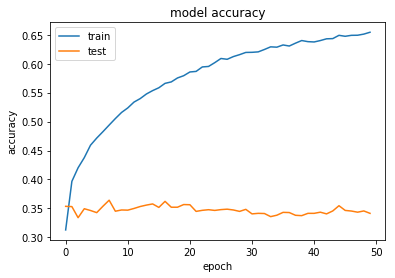

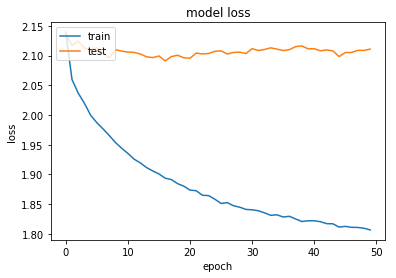

In [44]:
vnn_model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=keras.optimizers.RMSprop(),
    metrics=["accuracy"],
)

history_vnn = vnn_model.fit(X_train,
                            y_train, 
                            batch_size=32, 
                            epochs=50,
                            validation_data=(X_test, y_test),
#                             validation_split=0.2
                            )

loss, accuracy = vnn_model.evaluate(X_train, y_train, verbose=1)

print("Training Accuracy: {:.4f}".format(accuracy))

loss, accuracy = vnn_model.evaluate(X_test, y_test, verbose=1)

print("Testing Accuracy:  {:.4f}".format(accuracy))

# list all data in history
print(history_vnn.history.keys())
# summarize history for accuracy
plt.plot(history_vnn.history['accuracy'])
plt.plot(history_vnn.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_vnn.history['loss'])
plt.plot(history_vnn.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## RNN and CNN With Embedding Layer

This set of networks uses df2, not df -> see end of <b>Processing the Tokens</b> code

#### Regular CNN

In [45]:
# encode the genres as numbers (factors)
labelencoder_y_1 = LabelEncoder()
y = labelencoder_y_1.fit_transform(df2['genre'])

# perform a test/train split on the data
X_train, X_test, y_train, y_test = train_test_split(df2['lyrics'], y, test_size=0.2, random_state=42)

# use Keras tokenizer to tokenize the words and give a numerical index to the word
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

# find out the size of the vocabulary and save it as a variable
vocab_size = len(tokenizer.word_index) + 1
vocab_size

# use the tokenizer on the train and test data
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

# find the average song length (by token count) by looping through each one and adding the length to a list
longest = []
for i in X_train:
    longest.append(len(i))
mean(longest)

# define the max length of the vectors as near this average
maxlen = 200

# pad the sequences if they don't reach the average length
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

print(X_train[0, :])

[ 448  479   40 4209   72  206   56  138  961  144 2287   65   14    5
  166   38    3   20   28 2275    4   52    1 1339   96   39    1  141
  105   54   44    3    8   20  151   82   70    3   48  728  492  479
   40 1316   72  206   56  138  258  144 2287   65   14    5  166   38
    3   20   28 2275    4   52    1 1339   96   39    1  141  105   54
   44    3    8   20  151   82    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0 

In [ ]:
# start = datetime.now()

# def cnn_embedding_model(num_filters, kernel_size, activation_1, activation_2, dense_nodes, optimizer):
#     model = Sequential()
    
#     model.add(layers.Embedding(vocab_size, output_dim=100, input_length=maxlen))
    
#     model.add(layers.Conv1D(num_filters, kernel_size, activation=activation_1))
    
#     model.add(layers.GlobalMaxPooling1D())
   
#     model.add(layers.Dense(dense_nodes, activation=activation_2))
    
#     model.add(layers.Dense(10, activation='softmax'))
    
#     model.compile(optimizer=optimizer,
#                   loss='sparse_categorical_crossentropy',
#                   metrics=['accuracy'])
    
#     return model

# param_grid = dict(num_filters=[32, 64, 128],
#                   kernel_size=[3, 5, 7],
#                   activation_1=['relu', 'tanh'], 
#                   activation_2=['relu', 'tanh'],
#                   dense_nodes=[64, 100, 128],
#                   optimizer=['adam', 'RMSprop'])

# from keras.wrappers.scikit_learn import KerasClassifier
# from sklearn.model_selection import RandomizedSearchCV

# # Main settings
# epochs = 5
# batch_size = 32
# maxlen = 200

# cnn_model = KerasClassifier(build_fn=cnn_embedding_model,
#                         epochs=epochs, 
#                         batch_size=batch_size,
#                         verbose=False)

# grid = RandomizedSearchCV(estimator=cnn_model, param_distributions=param_grid, cv=5, verbose=1, n_iter=5)

# grid_result = grid.fit(X_train, y_train)

# # Evaluate testing set
# test_accuracy = grid.score(X_test, y_test)

# print("Overall Run Time:", datetime.now()-start)

In [65]:
cnn_model = Sequential()
cnn_model.add(layers.Embedding(input_dim=vocab_size, 
                               output_dim=100, 
                               input_length=maxlen))

cnn_model.add(layers.Conv1D(256, 5, activation='relu'))
cnn_model.add(layers.Dropout(0.5))
cnn_model.add(layers.MaxPooling1D())

cnn_model.add(layers.Conv1D(256, 5, activation='relu'))
cnn_model.add(layers.Dropout(0.5))
cnn_model.add(layers.GlobalMaxPooling1D())

cnn_model.add(layers.Dense(64, activation='relu'))

cnn_model.add(layers.Dense(10, activation='softmax'))

cnn_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

cnn_model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 200, 100)          10271000  
_________________________________________________________________
conv1d_19 (Conv1D)           (None, 196, 256)          128256    
_________________________________________________________________
dropout_13 (Dropout)         (None, 196, 256)          0         
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 98, 256)           0         
_________________________________________________________________
conv1d_20 (Conv1D)           (None, 94, 256)           327936    
_________________________________________________________________
dropout_14 (Dropout)         (None, 94, 256)           0         
_________________________________________________________________
global_max_pooling1d_8 (Glob (None, 256)             

In [66]:
history_cnn = cnn_model.fit(X_train, y_train,
                        epochs=50,
                        verbose=1,
#                         validation_split=0.2,
                        validation_data=(X_test, y_test),
                        batch_size=32)

loss, accuracy = cnn_model.evaluate(X_train, y_train, verbose=1)

print("Training Accuracy: {:.4f}".format(accuracy))

loss, accuracy = cnn_model.evaluate(X_test, y_test, verbose=1)

print("Testing Accuracy:  {:.4f}".format(accuracy))

# list all data in history
print(history_cnn.history.keys())
# summarize history for accuracy
plt.plot(history_cnn.history['accuracy'])
plt.plot(history_cnn.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_cnn.history['loss'])
plt.plot(history_cnn.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

C:\Users\blitz\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 26080 samples, validate on 6520 samples
Epoch 1/50
26080/26080 [==============================] - 152s 6ms/step - loss: 2.0058 - accuracy: 0.2763 - val_loss: 1.9570 - val_accuracy: 0.3598
Epoch 2/50
26080/26080 [==============================] - 152s 6ms/step - loss: 1.7465 - accuracy: 0.3884 - val_loss: 1.9060 - val_accuracy: 0.3897
Epoch 3/50
26080/26080 [==============================] - 152s 6ms/step - loss: 1.5934 - accuracy: 0.4477 - val_loss: 1.8509 - val_accuracy: 0.3991
Epoch 4/50
26080/26080 [==============================] - 152s 6ms/step - loss: 1.4777 - accuracy: 0.4907 - val_loss: 1.8313 - val_accuracy: 0.4087- loss: 1.4721 - accuracy:  - ETA: 6s - loss: 1.4 - ETA: 4s - loss: 1.4768 - accura - E
Epoch 5/50
26080/26080 [==============================] - 151s 6ms/step - loss: 1.3777 - accuracy: 0.5249 - val_loss: 1.8101 - val_accuracy: 0.4120
Epoch 6/50
26080/26080 [==============================] - 151s 6ms/step - loss: 1.2767 - accuracy: 0.5607 - val_loss: 1.7937

KeyboardInterrupt: 

#### Regular RNN

In [69]:
# encode the genres as numbers (factors)
labelencoder_y_1 = LabelEncoder()
y = labelencoder_y_1.fit_transform(df2['genre'])

# perform a test/train split on the data
X_train, X_test, y_train, y_test = train_test_split(df2['lyrics'], y, test_size=0.2, random_state=42)

# use Keras tokenizer to tokenize the words and give a numerical index to the word
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

# find out the size of the vocabulary and save it as a variable
vocab_size = len(tokenizer.word_index) + 1
vocab_size

# use the tokenizer on the train and test data
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

# find the average song length (by token count) by looping through each one and adding the length to a list
longest = []
for i in X_train:
    longest.append(len(i))
mean(longest)

# define the max length of the vectors as near this average
maxlen = 200

# pad the sequences if they don't reach the average length
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

print(X_train[0, :])

[ 448  479   40 4209   72  206   56  138  961  144 2287   65   14    5
  166   38    3   20   28 2275    4   52    1 1339   96   39    1  141
  105   54   44    3    8   20  151   82   70    3   48  728  492  479
   40 1316   72  206   56  138  258  144 2287   65   14    5  166   38
    3   20   28 2275    4   52    1 1339   96   39    1  141  105   54
   44    3    8   20  151   82    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0 

In [70]:
rnn_model = Sequential()
rnn_model.add(layers.Embedding(input_dim=vocab_size, 
                               output_dim=100, 
                               input_length=maxlen))

rnn_model.add(layers.SpatialDropout1D(0.2))

rnn_model.add(layers.LSTM(100, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))

rnn_model.add(layers.Flatten())

rnn_model.add(layers.Dense(10, activation='softmax'))

rnn_model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

rnn_model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, 200, 100)          10271000  
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 200, 100)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 200, 100)          80400     
_________________________________________________________________
flatten_2 (Flatten)          (None, 20000)             0         
_________________________________________________________________
dense_18 (Dense)             (None, 10)                200010    
Total params: 10,551,410
Trainable params: 10,551,410
Non-trainable params: 0
_________________________________________________________________


C:\Users\blitz\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 26080 samples, validate on 6520 samples
Epoch 1/20
26080/26080 [==============================] - 178s 7ms/step - loss: 1.9274 - accuracy: 0.3180 - val_loss: 1.7740 - val_accuracy: 0.3883
Epoch 2/20
26080/26080 [==============================] - 177s 7ms/step - loss: 1.6344 - accuracy: 0.4373 - val_loss: 1.7731 - val_accuracy: 0.3931
Epoch 3/20
26080/26080 [==============================] - 177s 7ms/step - loss: 1.4061 - accuracy: 0.5242 - val_loss: 1.8104 - val_accuracy: 0.4012
Epoch 4/20
26080/26080 [==============================] - 177s 7ms/step - loss: 1.1612 - accuracy: 0.6097 - val_loss: 1.9646 - val_accuracy: 0.3827
Epoch 5/20
26080/26080 [==============================] - 177s 7ms/step - loss: 0.9079 - accuracy: 0.6985 - val_loss: 2.1805 - val_accuracy: 0.3782
Epoch 6/20
26080/26080 [==============================] - 176s 7ms/step - loss: 0.7118 - accuracy: 0.7616 - val_loss: 2.4639 - val_accuracy: 0.3768
Epoch 7/20
26080/26080 [==============================] - 177s 

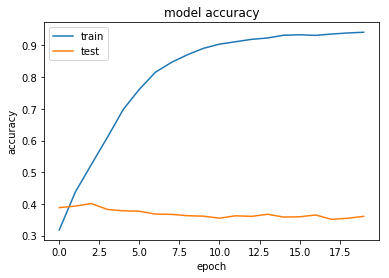

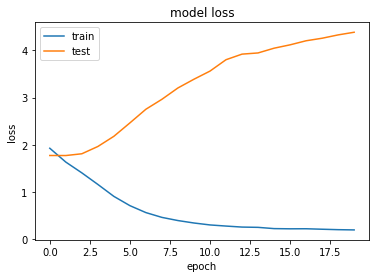

In [71]:
history_rnn = rnn_model.fit(X_train, y_train,
                        epochs=20,
                        verbose=1,
#                         validation_split=0.1,
                        validation_data=(X_test, y_test),
                        batch_size=32)

loss, accuracy = rnn_model.evaluate(X_train, y_train, verbose=1)

print("Training Accuracy: {:.4f}".format(accuracy))

loss, accuracy = rnn_model.evaluate(X_test, y_test, verbose=1)

print("Testing Accuracy:  {:.4f}".format(accuracy))

# list all data in history
print(history_rnn.history.keys())
# summarize history for accuracy
plt.plot(history_rnn.history['accuracy'])
plt.plot(history_rnn.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_rnn.history['loss'])
plt.plot(history_rnn.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### RNN and CNN Combined

In [72]:
# encode the genres as numbers (factors)
labelencoder_y_1 = LabelEncoder()
y = labelencoder_y_1.fit_transform(df2['genre'])

# perform a test/train split on the data
X_train, X_test, y_train, y_test = train_test_split(df2['lyrics'], y, test_size=0.2, random_state=42)

# use Keras tokenizer to tokenize the words and give a numerical index to the word
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

# find out the size of the vocabulary and save it as a variable
vocab_size = len(tokenizer.word_index) + 1
vocab_size

# use the tokenizer on the train and test data
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

# find the average song length (by token count) by looping through each one and adding the length to a list
longest = []
for i in X_train:
    longest.append(len(i))
mean(longest)

# define the max length of the vectors as near this average
maxlen = 200

# pad the sequences if they don't reach the average length
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

print(X_train[0, :])

[ 448  479   40 4209   72  206   56  138  961  144 2287   65   14    5
  166   38    3   20   28 2275    4   52    1 1339   96   39    1  141
  105   54   44    3    8   20  151   82   70    3   48  728  492  479
   40 1316   72  206   56  138  258  144 2287   65   14    5  166   38
    3   20   28 2275    4   52    1 1339   96   39    1  141  105   54
   44    3    8   20  151   82    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0 

In [73]:
vocab_size

102710

Two-stream approach

In [74]:
# use Keras functional API to make a easier-to-read flow of the network

inputs = keras.Input(shape=(200,))

embed = layers.Embedding(vocab_size,100)(inputs)

x = layers.Conv1D(256, 5, activation='relu')(embed)
x = layers.GlobalMaxPooling1D()(x)

y = layers.SpatialDropout1D(0.2)(embed)
y = layers.LSTM(100, dropout=0.2, recurrent_dropout=0.2, return_sequences=True)(y)
y = layers.Flatten()(y)

merge_layer = layers.concatenate([x, y])
z = layers.Dense(256, activation="relu")(merge_layer)
z = layers.Dense(128, activation="relu")(z)

outputs = layers.Dense(10, activation='softmax')(z)

model_rnncnn1 = keras.Model(inputs=inputs, outputs=outputs, name="cnn_rnn_split_model")

model_rnncnn1.summary()

Model: "cnn_rnn_split_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 200)          0                                            
__________________________________________________________________________________________________
embedding_15 (Embedding)        (None, 200, 100)     10271000    input_2[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_3 (SpatialDro (None, 200, 100)     0           embedding_15[0][0]               
__________________________________________________________________________________________________
conv1d_21 (Conv1D)              (None, 196, 256)     128256      embedding_15[0][0]               
________________________________________________________________________________

C:\Users\blitz\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 20864 samples, validate on 5216 samples
Epoch 1/20
20864/20864 [==============================] - 155s 7ms/step - loss: 2.1884 - accuracy: 0.2556 - val_loss: 2.1568 - val_accuracy: 0.2903
Epoch 2/20
20864/20864 [==============================] - 159s 8ms/step - loss: 2.1247 - accuracy: 0.3252 - val_loss: 2.1347 - val_accuracy: 0.3183
Epoch 3/20
20864/20864 [==============================] - 159s 8ms/step - loss: 2.0804 - accuracy: 0.3755 - val_loss: 2.1185 - val_accuracy: 0.3321
Epoch 4/20
20864/20864 [==============================] - 161s 8ms/step - loss: 2.0468 - accuracy: 0.4081 - val_loss: 2.1016 - val_accuracy: 0.3507
Epoch 5/20
20864/20864 [==============================] - 158s 8ms/step - loss: 2.0094 - accuracy: 0.4475 - val_loss: 2.1025 - val_accuracy: 0.3526
Epoch 6/20
20864/20864 [==============================] - 157s 8ms/step - loss: 1.9765 - accuracy: 0.4815 - val_loss: 2.0992 - val_accuracy: 0.3556
Epoch 7/20
20864/20864 [==============================] - 155s 

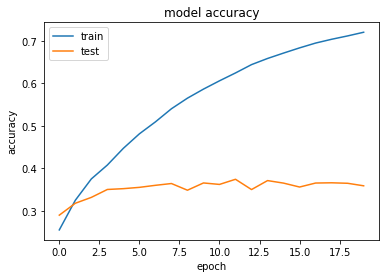

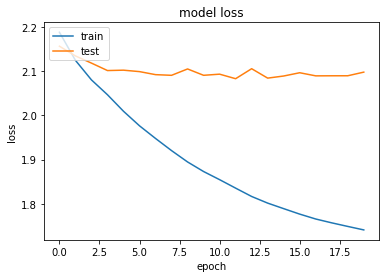

In [76]:
model_rnncnn1.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=keras.optimizers.RMSprop(),
    metrics=["accuracy"],
)

history_rnncnn1 = model_rnncnn1.fit(X_train,
                                    y_train, 
                                    batch_size=64, 
                                    validation_split=0.2,
#                                     validation_data=(X_test, y_test),
                                    epochs=20,)

loss, accuracy = model_rnncnn1.evaluate(X_train, y_train, verbose=1)

print("Training Accuracy: {:.4f}".format(accuracy))

loss, accuracy = model_rnncnn1.evaluate(X_test, y_test, verbose=1)

print("Testing Accuracy:  {:.4f}".format(accuracy))

# list all data in history
print(history_rnncnn1.history.keys())
# summarize history for accuracy
plt.plot(history_rnncnn1.history['accuracy'])
plt.plot(history_rnncnn1.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_rnncnn1.history['loss'])
plt.plot(history_rnncnn1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

CNN into RNN approach (https://www.aclweb.org/anthology/C16-1229.pdf)

In [77]:
# use Keras functional API to make a easier-to-read flow of the network

inputs = keras.Input(shape=(200,))

embed = layers.Embedding(vocab_size,100)(inputs)

x1 = layers.Conv1D(256, 5, activation='relu')(embed)
x1 = layers.GlobalMaxPooling1D()(x1)

x2 = layers.Conv1D(256, 5, activation='relu')(embed)
x2 = layers.GlobalMaxPooling1D()(x2)

x3 = layers.Conv1D(256, 5, activation='relu')(embed)
x3 = layers.GlobalMaxPooling1D()(x3)

# merge_layer = layers.concatenate(axis=-1)([x1, x2])
merge_layer = layers.Concatenate(axis=-1)([x1, x2, x3])
res = layers.Reshape((3, 256))(merge_layer)

y = layers.SpatialDropout1D(0.2)(res)
y = layers.LSTM(100, dropout=0.2, recurrent_dropout=0.2, return_sequences=True)(y)
y = layers.Flatten()(y)

outputs = layers.Dense(10, activation='softmax')(y)

model_rnncnn2 = keras.Model(inputs=inputs, outputs=outputs, name="cnn_to_rnn_model")

model_rnncnn2.summary()

Model: "cnn_to_rnn_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 200)          0                                            
__________________________________________________________________________________________________
embedding_16 (Embedding)        (None, 200, 100)     10271000    input_3[0][0]                    
__________________________________________________________________________________________________
conv1d_22 (Conv1D)              (None, 196, 256)     128256      embedding_16[0][0]               
__________________________________________________________________________________________________
conv1d_23 (Conv1D)              (None, 196, 256)     128256      embedding_16[0][0]               
___________________________________________________________________________________

C:\Users\blitz\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 26080 samples, validate on 6520 samples
Epoch 1/20
26080/26080 [==============================] - 102s 4ms/step - loss: 2.1982 - accuracy: 0.2410 - val_loss: 2.1345 - val_accuracy: 0.3118
Epoch 2/20
26080/26080 [==============================] - 101s 4ms/step - loss: 2.1267 - accuracy: 0.3235 - val_loss: 2.1065 - val_accuracy: 0.3439
Epoch 3/20
26080/26080 [==============================] - 101s 4ms/step - loss: 2.0905 - accuracy: 0.3630 - val_loss: 2.0913 - val_accuracy: 0.3627
Epoch 4/20
26080/26080 [==============================] - 102s 4ms/step - loss: 2.0596 - accuracy: 0.3954 - val_loss: 2.0943 - val_accuracy: 0.3584
Epoch 5/20
26080/26080 [==============================] - 101s 4ms/step - loss: 2.0327 - accuracy: 0.4224 - val_loss: 2.0806 - val_accuracy: 0.3716
Epoch 6/20
26080/26080 [==============================] - 101s 4ms/step - loss: 2.0025 - accuracy: 0.4563 - val_loss: 2.0710 - val_accuracy: 0.3821
Epoch 7/20
26080/26080 [==============================] - 101s 

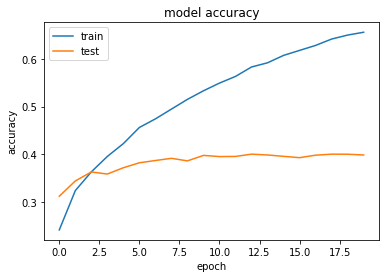

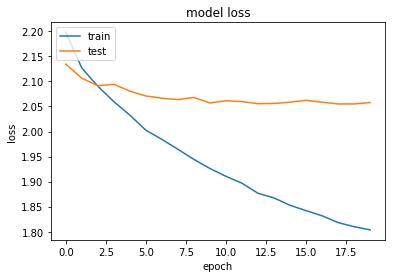

In [78]:
model_rnncnn2.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=keras.optimizers.RMSprop(),
    metrics=["accuracy"],
)

history_rnncnn2 = model_rnncnn2.fit(X_train,
                                    y_train, 
                                    batch_size=64, 
                                    epochs=20,
#                                     validation_split=0.2,
                                    validation_data=(X_test, y_test))

loss, accuracy = model_rnncnn2.evaluate(X_train, y_train, verbose=1)

print("Training Accuracy: {:.4f}".format(accuracy))

loss, accuracy = model_rnncnn2.evaluate(X_test, y_test, verbose=1)

print("Testing Accuracy:  {:.4f}".format(accuracy))

# list all data in history
print(history_rnncnn2.history.keys())
# summarize history for accuracy
plt.plot(history_rnncnn2.history['accuracy'])
plt.plot(history_rnncnn2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_rnncnn2.history['loss'])
plt.plot(history_rnncnn2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# <font color='red'>Hierarchical Attention Network -> IGNORE EVERYTHING BELOW FOR NOW!</font>

Make an embedding matrix

### Setting Up The Model

Setting up the layers of the model

In [ ]:
#####################################################################################################################
# define the attention layer (from https://humboldt-wi.github.io/blog/research/information_systems_1819/group5_han/)
#####################################################################################################################
"""
    Hierarchial Attention Layer as described by Hierarchical Attention Networks for Document Classification(2016)
    - Yang et. al.
    Source: https://www.cs.cmu.edu/~hovy/papers/16HLT-hierarchical-attention-networks.pdf
    Theano backend
"""

class AttentionLayer(keras.layers.Layer):

    def __init__(self,attention_dim=100,return_coefficients=False,**kwargs):
        # Initializer 
        self.supports_masking = True
        self.return_coefficients = return_coefficients
        self.init = initializers.get('glorot_uniform') # initializes values with uniform distribution
        self.attention_dim = attention_dim
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        # Builds all weights
        # W = Weight matrix, b = bias vector, u = context vector
        assert len(input_shape) == 3
        self.W = K.variable(self.init((input_shape[-1], self.attention_dim)),name='W')
        self.b = K.variable(self.init((self.attention_dim, )),name='b')
        self.u = K.variable(self.init((self.attention_dim, 1)),name='u')
        self.trainable_weights = [self.W, self.b, self.u]

        super(AttentionLayer, self).build(input_shape)

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, hit, mask=None):
        # Here, the actual calculation is done
        uit = K.bias_add(K.dot(hit, self.W),self.b)
        uit = K.tanh(uit)
        
        ait = K.dot(uit, self.u)
        ait = K.squeeze(ait, -1)
        ait = K.exp(ait)
        
        if mask is not None:
            ait *= K.cast(mask, K.floatx())

        ait /= K.cast(K.sum(ait, axis=1, keepdims=True) + K.epsilon(), K.floatx())
        ait = K.expand_dims(ait)
        weighted_input = hit * ait
        
        if self.return_coefficients:
            return [K.sum(weighted_input, axis=1), ait]
        else:
            return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        if self.return_coefficients:
            return [(input_shape[0], input_shape[-1]), (input_shape[0], input_shape[-1], 1)]
        else:
            return input_shape[0], input_shape[-1]

In [ ]:
##################################################################################################################
# define the model layers (from https://humboldt-wi.github.io/blog/research/information_systems_1819/group5_han/)
##################################################################################################################

# Parameters
MAX_SENTENCE_NUM = 30
MAX_WORD_NUM = 40
MAX_FEATURES = vocab_len

# Words level attention model
word_input = Input(shape=(MAX_WORD_NUM,), dtype='int32',name='word_input')
word_sequences = embedding_layer(word_input)
word_gru = Bidirectional(GRU(50, return_sequences=True),name='word_gru')(word_sequences)
word_dense = Dense(100, activation='relu', name='word_dense')(word_gru) 
word_att,word_coeffs = AttentionLayer(EMBED_SIZE,True,name='word_attention')(word_dense)
wordEncoder = Model(inputs = word_input,outputs = word_att)

# Sentence level attention model
sent_input = Input(shape=(MAX_SENTENCE_NUM,MAX_WORD_NUM), dtype='int32',name='sent_input')
sent_encoder = TimeDistributed(wordEncoder,name='sent_linking')(sent_input)
sent_gru = Bidirectional(GRU(50, return_sequences=True),name='sent_gru')(sent_encoder)
sent_dense = Dense(100, activation='relu', name='sent_dense')(sent_gru) 
sent_att,sent_coeffs = AttentionLayer(EMBED_SIZE,return_coefficients=True,name='sent_attention')(sent_dense)
sent_drop = Dropout(0.5,name='sent_dropout')(sent_att)
preds = Dense(5, activation='softmax',name='output')(sent_drop)

In [ ]:
# compile model
model = Model(sent_input, preds)
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['acc'])
print(wordEncoder.summary())
print(model.summary())

In [ ]:
# train the model
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=7, batch_size=32)

### Use Word2Vec For Embeddings

In [17]:
# turn the lyrics into a list of sentences (assuming each line is the equivilent of a sentence)

# create a blank list
result = []

# loop through every lyric
for i in tqdm(lyr_list):
    tmp = []
    
    # if the entry is a newline indicator, remove it and start a new list tmp
    for entry in i:
        if entry != '\n ':
            tmp.append(entry)
        else:
            result.append(tmp)
            tmp = []
    result.append(tmp)

result

C:\Users\blitz\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


[['think', 'hear', 'voice', 'yesterday'],
 ['when', 'turn', 'around', 'to', 'say'],
 ['that', 'love', 'baby'],
 ['realize', 'be', 'just', 'mind'],
 ['play', 'trick', 'on'],
 ['and', 'seem', 'cold', 'lately', 'at', 'night'],
 ['and', 'try', 'to', 'sleep', 'with', 'the', 'light', 'on'],
 ['every', 'time', 'the', 'phone', 'ring'],
 ['pray', 'to', 'God', 'be'],
 ['and', 'just', 'can', 'not', 'believe'],
 ['that', 'be', 'through'],
 ['miss'],
 ['there', 'be', 'no', 'other', 'way', 'to', 'say'],
 ['and', 'can', 'not', 'deny'],
 ['miss'],
 ['be', 'so', 'easy', 'to', 'see'],
 ['miss', 'and'],
 ['be', 'turn', 'over', 'this', 'time'],
 ['have', 'really', 'change', 'mind', 'about', 'each', 'other', "'s", 'love'],
 ['all', 'the', 'feeling', 'that', 'use', 'to', 'share'],
 ['refuse', 'to', 'believe'],
 ['that', 'do', 'not', 'care'],
 ['miss'],
 ['there', 'be', 'no', 'other', 'way', 'to', 'say'],
 ['and', 'and', 'can', 'not', 'deny'],
 ['miss'],
 ['be', 'so', 'easy', 'to', 'see'],
 ['miss', 'and'],


In [18]:
result2 = []

# loop through every line, pulling the index and the actual list
for index, value in tqdm(enumerate(result)):

    # lowercase everyhing and turn into a string
    temp_lower = [x.lower() for x in value]
    temp = " ".join(temp_lower)
    
    # skip the line if it is a verse indicator
    if re.search(r"verse [1-9]", temp):
        continue
        
    # remove any song markers from the data (these are single item lists with values that indicate song parts)
    if temp != 'chorus' and temp != 'intro' and temp != 'outro hook' and temp != 'bridge' and temp != 'pre hook' and temp != 'hook':
        result2.append(temp_lower)

C:\Users\blitz\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


In [19]:
result2[0]

['think', 'hear', 'voice', 'yesterday']

In [20]:
# create the word2vec model based on the lyrics corpus
w2v_model = gensim.models.Word2Vec(result2, min_count=5, workers=4, size=100)

In [21]:
# test a value to see the vector
w2v_model['yesterday']

C:\Users\blitz\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


array([ 4.3283772e-01,  1.4335864e+00, -1.7664821e+00,  4.3703961e-01,
        1.3191137e+00,  1.8975000e+00,  1.1984626e+00, -4.1129452e-01,
        6.8580699e-01, -3.6758894e-01, -6.0178936e-01,  6.2423676e-01,
       -9.7002947e-01,  1.2917686e+00, -1.1202073e+00, -2.9131788e-01,
       -3.4717828e-01, -5.7396936e-01,  1.4871296e-01, -7.2570139e-01,
       -1.1832834e-01, -6.9199044e-01,  6.3340080e-01,  7.0754057e-01,
       -4.1724154e-01, -4.1730311e-02, -6.9686675e-01, -1.1093780e+00,
        4.4056216e-01,  1.3571025e+00, -1.5729825e-01, -1.9833639e-01,
       -1.6182265e+00, -3.8581944e-01,  6.5323168e-01, -2.5185885e-02,
       -3.9590884e-02, -1.1690814e-01,  2.5967041e-01,  6.6333759e-01,
       -3.3900586e-01,  5.2886319e-01, -1.0311929e+00,  2.3941720e-01,
        5.7621361e-03,  4.5912898e-01,  4.3914855e-01,  2.1193602e+00,
       -1.3468895e+00,  7.1861601e-01, -1.0856527e+00, -7.6050991e-01,
        1.6328982e-03, -2.5321501e-01, -7.2204876e-01, -7.7476412e-01,
      

In [22]:
# number of words in the vocab
vocab_len = len(w2v_model.wv.vocab)
vocab_len

35539